# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [87]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

In [4]:
def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

#leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [112]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
# create panda dates series for displaying on the axis
dates = pd.date_range(start='20170101', end='20171231', freq='D', tz=None)
# and a mapping between day of the year and the day
day_of_year_mapping = {x.timetuple().tm_yday:x for x in dates }

In [113]:
# remove leap year, convert degrees into a degrees, not tenths
from datetime import datetime
# convert to date object
df['Date'] = [ x for x in pd.to_datetime(df['Date']) ] 
# determine the day of the year
df['day_of_year'] = [ x.timetuple().tm_yday for x in df['Date'] ] 
# find the leap years
df['leap_year'] = [ x.timetuple().tm_year in [2016,2012,2008,2004,2000] for x in df['Date'] ] 
# remove feb 29th
df = df[ ~ ( (df.day_of_year == 60) & (df.leap_year) ) ]

# decrease the day of the year 
def update_day_of_year(row):
    if not row['leap_year']:
        return row['day_of_year']
    elif row['day_of_year'] > 60:
        return row['day_of_year'] - 1
    else:
        return row['day_of_year']
# make the day of the year consistent across the leap years
df['doy'] = df.apply(update_day_of_year, axis=1)
# convert the temperatures to actual degrees instead of the tenths business
df['Data_Value'] = df['Data_Value'].apply(lambda x: x / 10)

# add 2017 date mapping ( for graphing)
df['date_2017'] = list(map( lambda x: day_of_year_mapping[x], df['doy']))


# ten year period df
ten_year_df = df[(df['Date']<'2015-01-01') & (df['Date']>'2003-12-31')  ]
# 2015 data
df_2015 = df[(df['Date']<'2016-01-01') & (df['Date']>'2014-12-31')  ]

In [115]:
# ten year high/low
max_series = ten_year_df[ten_year_df['Element'] == 'TMAX'].groupby(['date_2017'])['Data_Value'].max()
min_series = ten_year_df[ten_year_df['Element'] == 'TMIN'].groupby(['date_2017'])['Data_Value'].min()
# 2015 high/low
max_series_2015 = df_2015[df_2015['Element'] == 'TMAX'].groupby(['date_2017'])['Data_Value'].max()
min_series_2015 = df_2015[df_2015['Element'] == 'TMIN'].groupby(['date_2017'])['Data_Value'].min()


### Dataframes where 10 year record was beat

In [143]:
# df where ten year record was beat
min_df = pd.DataFrame(data={'data_val_10y':min_series, 'data_val_2015':min_series_2015})
min_df = min_df[ min_df['data_val_2015'] < min_df['data_val_10y'] ].reset_index()

max_df = pd.DataFrame(data={'data_val_10y':max_series, 'data_val_2015':max_series_2015})
max_df = max_df[ max_df['data_val_2015'] > max_df['data_val_10y'] ].reset_index()


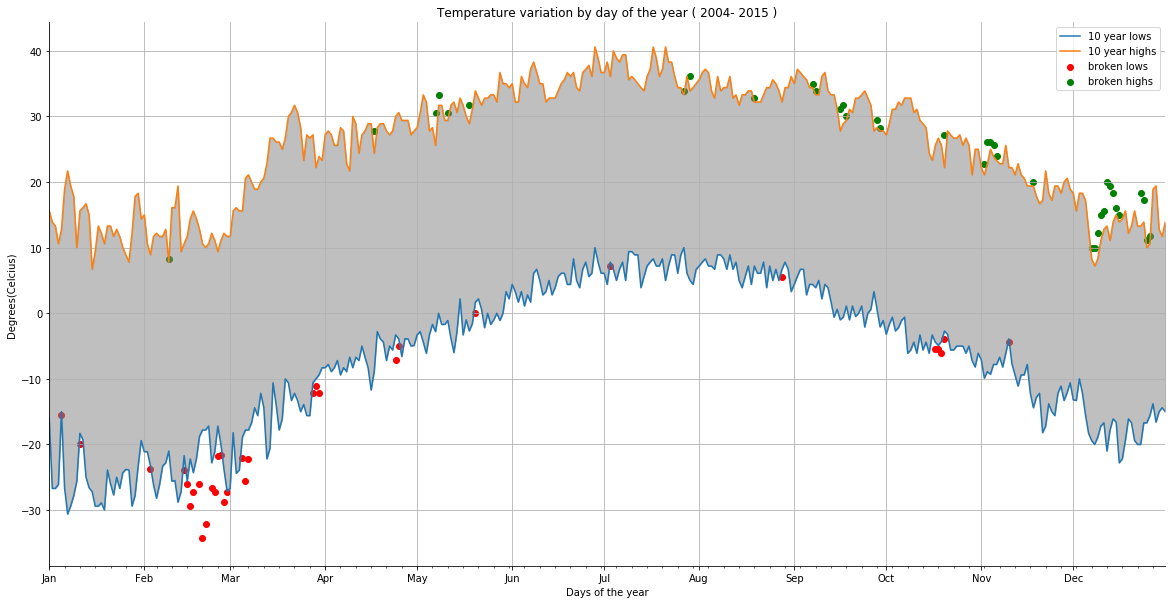

In [148]:
# what do I want here
# X label
# Y Label
# legend
# on X-Axis, I want Months on major ticks and days on minor
# Make it larger

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# fig for saving later
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(dates, min_series.values, label = '10 year lows')
ax.plot(dates, max_series.values, label = '10 year highs')
monthFmt = mdates.DateFormatter('%b')

# every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# with this format
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.grid(True)

ax.set_xlim('2017-01-01','2017-12-31')

ax.scatter(x=min_df['date_2017'].values, y=min_df['data_val_2015'].values, c=['red'], label='broken lows')
ax.scatter(x=max_df['date_2017'].values, y=max_df['data_val_2015'].values, c=['green'], label='broken highs')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.fill_between(dates, max_series.values, min_series.values, color='grey', alpha=0.5)
plt.ylabel('Degrees(Celcius)')
plt.xlabel('Days of the year')
plt.title('Temperature variation by day of the year ( 2004- 2015 )')

ax.legend()
plt.show()
#plt.savefig('myplot.png')

